In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from faker import Faker
import os
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow import keras
from tensorflow import losses

In [3]:
# Creating folders to save generated data
path = os.getcwd()
# os.mkdir(path+"/validation_data")
# os.mkdir(path+"/validation_data/positive")
# os.mkdir(path+"/validation_data/negative")

In [3]:
# Set a set to get deterministic results
fake = Faker()
Faker.seed(4321)

In [4]:
# Functions to generate dummy data
def create_transposed_data(n: int, path: str):
    with open(path, "w+") as f:
        for i in range(n):
            name = fake.first_name()
            last_name = fake.last_name()
            f.write(f"{name}|{last_name}|{last_name}|{name}\n")

def create_non_transposed_data(n: int, path: str):
    with open(path, "w+") as f:
        for i in range(n):
            name = fake.first_name()
            last_name = fake.last_name()
            second_name = fake.first_name()
            second_last_name = fake.last_name()
            f.write(f"{name}|{last_name}|{second_name}|{second_last_name}\n")

In [16]:
# creating training data
create_transposed_data(60000, path+"/text_data/positive.txt")
create_non_transposed_data(60000, path+"/text_data/negative.txt")

In [8]:
# creating validation data
Faker.seed(1234)
create_transposed_data(10000, path+"/validation_data/positive.txt")
create_non_transposed_data(10000, path+"/validation_data/negative.txt")

### Loading Data

In [4]:
positive = pd.read_csv(path+"/text_data/positive.txt", sep="|", dtype="str", header=None)
negative = pd.read_csv(path+"/text_data/negative.txt", sep="|", dtype="str", header=None)

In [5]:
display(positive.head())
display(negative.head())


,0,1,2,3
0,Andrea,Hernandez,Hernandez,Andrea
1,Linda,Williams,Williams,Linda
2,Amy,Chapman,Chapman,Amy
3,Brenda,Mcmahon,Mcmahon,Brenda
4,Shane,Rowe,Rowe,Shane


,0,1,2,3
0,Kayla,Clay,Alejandra,Irwin
1,Carlos,Caldwell,Neil,Thomas
2,Brian,Clark,Stephanie,Mason
3,Michelle,Gray,Tanya,Lopez
4,Mary,Hicks,Michael,Wilson


In [6]:
all_data = pd.concat([positive,negative]).reset_index(drop=True)
display(all_data.tail())
display(all_data.shape)

,0,1,2,3
119995,Jonathan,Randall,Erin,Smith
119996,Ronald,Walker,Joel,Fields
119997,Carla,Williams,Darlene,Russell
119998,Elizabeth,King,Nicole,Clarke
119999,Emily,Herman,Robert,Crane


(120000, 4)

In [7]:
# Generate labels
labels = np.concatenate([np.ones(60000),np.zeros(60000)])

## Building the net

### Creating preprocessing layer

In [8]:
max_features = 100000
sequence_length = 16

vectorize_layer = layers.TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=max_features,
    ngrams=1,
    output_mode='int',
    output_sequence_length=sequence_length)

In [9]:
text_dataset = tf.data.Dataset.from_tensor_slices(np.concatenate([all_data[i].to_numpy() for i in range(4)]))
vectorize_layer.adapt(text_dataset.batch(64))

2023-10-15 12:42:55.890350: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [480000]
	 [[{{node Placeholder/_0}}]]


### Building the body

In [10]:
# Creating symbolic tensors
inputs = { f"name_{i}": tf.keras.Input(shape=(1,), name=f"name_{i}", dtype=tf.string) for i in range(1,5)}
inputs

{'name_1': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'name_1')>,
 'name_2': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'name_2')>,
 'name_3': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'name_3')>,
 'name_4': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'name_4')>}

In [11]:
# embedding
embedding_dim = 16
embdd = layers.Embedding(max_features + 1, embedding_dim)

In [12]:
preprocessed_inputs = []
for name, input in inputs.items():
  x = vectorize_layer(input)
  x = embdd(x)
  x = layers.LSTM(12,input_dim=embedding_dim)(x)
  preprocessed_inputs.append(x)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 name_1 (InputLayer)         [(None, 1)]                  0         []                            
                                                                                                  
 name_2 (InputLayer)         [(None, 1)]                  0         []                            
                                                                                                  
 name_3 (InputLayer)         [(None, 1)]                  0         []                            
                                                                                                  
 name_4 (InputLayer)         [(None, 1)]                  0         []                            
                                                                                              

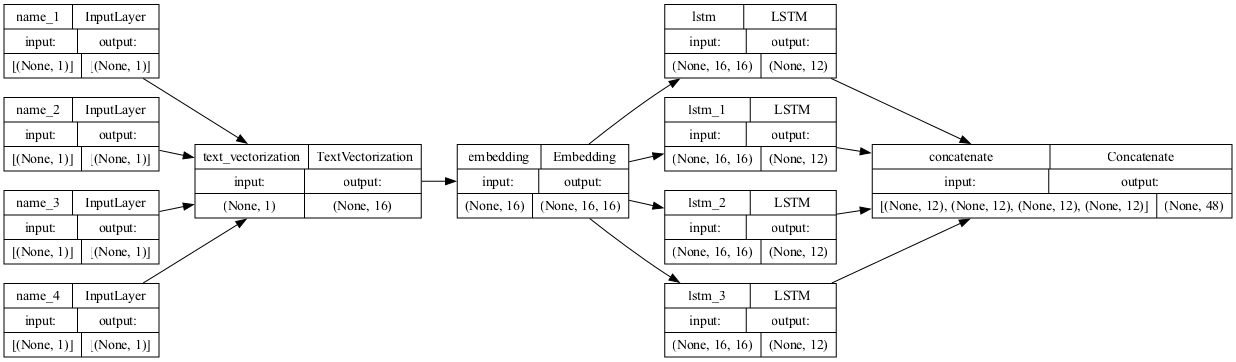

In [13]:
preprocessed_inputs_cat = layers.Concatenate()(preprocessed_inputs)

model_preprocessing = tf.keras.Model(inputs, preprocessed_inputs_cat)

model_preprocessing.summary()

tf.keras.utils.plot_model(model = model_preprocessing , rankdir="LR", dpi=72, show_shapes=True)

In [14]:
names_dict = {f"name_{i+1}": np.array(value) 
                         for i, value in all_data.items()}
training_features = {name: np.array(value) for name, value in names_dict.items()}


In [15]:
preprocessed_inputs = model_preprocessing(inputs)

deep_layers = tf.keras.Sequential([
    layers.Dense(1),
    layers.Activation('sigmoid')
  ])

result = deep_layers(preprocessed_inputs)

model = tf.keras.Model(inputs, result)

model.compile(loss=losses.BinaryCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.legacy.Adam(),
              metrics=['accuracy'])

In [16]:
model.fit(x=training_features, y=labels, epochs=3, validation_split=0.05)

Epoch 1/3
3563/3563 [==============================] - 26s 7ms/step - loss: 0.0506 - accuracy: 0.9745 - val_loss: 0.0087 - val_accuracy: 0.9967
Epoch 2/3
3563/3563 [==============================] - 23s 7ms/step - loss: 0.0033 - accuracy: 0.9992 - val_loss: 0.0040 - val_accuracy: 0.9987
Epoch 3/3
3563/3563 [==============================] - 24s 7ms/step - loss: 0.0018 - accuracy: 0.9995 - val_loss: 0.0031 - val_accuracy: 0.9987


In [17]:
history = model.history

In [18]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

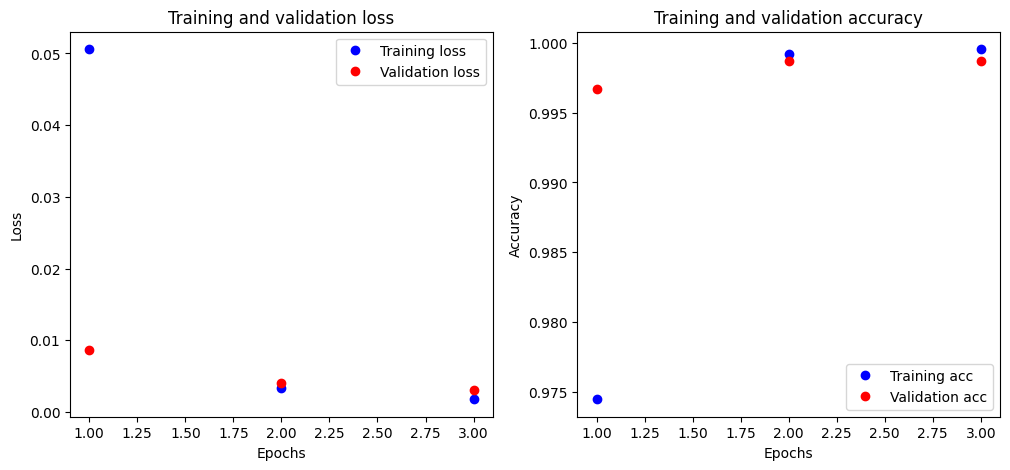

In [19]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

fig, ax = plt.subplots(1,2,figsize=(12,5))

ax[0].plot(epochs, loss, 'bo', label='Training loss')
ax[0].plot(epochs, val_loss, 'ro', label='Validation loss')
ax[0].set_title('Training and validation loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(epochs, acc, 'bo', label='Training acc')
ax[1].plot(epochs, val_acc, 'ro', label='Validation acc')
ax[1].set_title('Training and validation accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend(loc='lower right')

#

## Evaluating the model

In [20]:
# Put test names below
dataset_1 = tf.data.Dataset.from_tensor_slices([ "Rene", "Rene",])
dataset_2 = tf.data.Dataset.from_tensor_slices(["Velazquez", "Velazquez",])
dataset_3 = tf.data.Dataset.from_tensor_slices(["Velazquez", "John",])
dataset_4 = tf.data.Dataset.from_tensor_slices(["Rene", "Doe",])
labels = tf.data.Dataset.from_tensor_slices([1])
zipped_input = tf.data.Dataset.zip(((dataset_1, dataset_2, dataset_3, dataset_4), )).batch(1)

In [21]:
a = model.predict(zipped_input)

2023-10-15 12:45:44.096507: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_6' with dtype string and shape [2]
	 [[{{node Placeholder/_6}}]]


2/2 [==============================] - 1s 3ms/step


In [22]:
for i, tensor in enumerate(zipped_input.as_numpy_iterator()):
    print([val[0] for val in tensor[0]])
    print(a[i])
    print("*"*10)

[b'Rene', b'Velazquez', b'Velazquez', b'Rene']
[0.9994758]
**********
[b'Rene', b'Velazquez', b'John', b'Doe']
[1.33242675e-05]
**********


As seen above the input  
    `Rene Velazquez Velazquez Rene`  
is recognized as a transposition, but  
    `Rene Velazquez John Doe`  
is not.  
 Try a few examples yourself!


In [23]:
model.save('models/transpositionDetector.keras')

In [24]:
positive = pd.read_csv(path+"/validation_data/positive.txt", sep="|", dtype="str", header=None)
negative = pd.read_csv(path+"/validation_data/negative.txt", sep="|", dtype="str", header=None)
validation = pd.concat([positive, negative])
labels = np.concatenate([np.ones(10000),np.zeros(10000)])

In [25]:
validation_features = np.array(validation).T
validation_features[0].shape

(20000,)

In [26]:
dataset_1 = tf.data.Dataset.from_tensor_slices(validation_features[0])
dataset_2 = tf.data.Dataset.from_tensor_slices(validation_features[1])
dataset_3 = tf.data.Dataset.from_tensor_slices(validation_features[2])
dataset_4 = tf.data.Dataset.from_tensor_slices(validation_features[3])
labels = tf.data.Dataset.from_tensor_slices(labels)

In [27]:
validation_dataset = tf.data.Dataset.zip(((dataset_1, dataset_2, dataset_3, dataset_4,), labels )).batch(32)

In [28]:
model.evaluate(validation_dataset)

2023-10-15 12:46:01.112374: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_6' with dtype string and shape [20000]
	 [[{{node Placeholder/_6}}]]


625/625 [==============================] - 1s 985us/step - loss: 0.0012 - accuracy: 0.9995


[0.0012280646478757262, 0.9995499849319458]

Getting a very high accuracy!

### Serve the model

In [29]:
model.export("transpositions")

INFO:tensorflow:Assets written to: transpositions/assets


INFO:tensorflow:Assets written to: transpositions/assets


Saved artifact at 'transpositions'. The following endpoints are available:

* Endpoint 'serve'
  Args:
    args_0: [<1>, <2>, <3>, <4>]
      <1>: string Tensor, shape=(None, 1)
      <2>: string Tensor, shape=(None, 1)
      <3>: string Tensor, shape=(None, 1)
      <4>: string Tensor, shape=(None, 1)
  Returns:
    float32 Tensor, shape=(None, 1)


In [39]:
reloaded_artifact = tf.saved_model.load("transpositions")

In [52]:
predicted_output = reloaded_artifact.serve([(tf.constant([["Rene"]], dtype="string")),tf.constant([["Velazquez"]], dtype="string"),tf.constant([["Velazquez"]], dtype="string"),tf.constant([["Rene"]], dtype="string")])

In [53]:
predicted_output

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.9994758]], dtype=float32)>